In [ ]:
!pip install efficientnet_pytorch fsspec s3fs boto3 > /dev/null

ERROR: aiobotocore 1.2.1 has requirement botocore<1.19.53,>=1.19.52, but you'll have botocore 1.20.22 which is incompatible.


In [8]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import boto3
from typing import List
from PIL import Image
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
model = EfficientNet.from_pretrained('efficientnet-b7')

Loaded pretrained weights for efficientnet-b7


In [10]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [11]:
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, 2)

In [13]:
df_stockprice_meta = pd.read_csv('s3://fin-app/stockprice_candlechart/metadata/DAILY_WINDOW-120d_STRIDE-30d_WIDTH-0.5/stockprice_metadata.csv')

In [14]:
df_stockprice_meta.head()

,s3_filepath,code,start_dt,end_dt,change_rate_30d
0,s3://fin-app/stockprice_candlechart/DAILY_WIND...,1301,1983-01-04,1983-05-04,-0.029299
1,s3://fin-app/stockprice_candlechart/DAILY_WIND...,1301,1983-02-03,1983-06-03,0.004054
2,s3://fin-app/stockprice_candlechart/DAILY_WIND...,1301,1983-03-05,1983-07-03,-0.024837
3,s3://fin-app/stockprice_candlechart/DAILY_WIND...,1301,1983-04-04,1983-08-02,-0.010135
4,s3://fin-app/stockprice_candlechart/DAILY_WIND...,1301,1983-05-04,1983-09-01,-0.027174


In [15]:
df_stockprice_meta['start_dt'] = pd.to_datetime(df_stockprice_meta['start_dt'])
df_stockprice_meta['end_dt'] = pd.to_datetime(df_stockprice_meta['end_dt'])

In [16]:
_aws_session = boto3.session.Session(
    region_name='ap-northeast-1',
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
)

S3_resource = _aws_session.resource('s3')

S3_BUCKET_NAME = 'fin-app'

class S3:

    @staticmethod
    def save_file(
        local_filepath: str,
        s3_filepath: str,
        bucket_name: str = S3_BUCKET_NAME,
    ) -> None:
        """[summary]
        Args:
            local_filepath (str): [description]
            s3_filepath (str): [description]
            bucket_name (str, optional): [description]. Defaults to AWSConfig.S3_BUCKET_NAME.
        """
        bucket = S3_resource.Bucket(bucket_name)

        bucket.upload_file(
            local_filepath,
            s3_filepath
        )

    @staticmethod
    def get_filelist(
        basedir: str,
        bucket_name: str = S3_BUCKET_NAME,
        marker: str = '',
    ) -> List[str]:
        """[summary]
        Args:
            basedir (str): [description]
            bucket_name (str, optional): [description]. Defaults to AWSConfig.S3_BUCKET_NAME.
            marker (str, optional): [description]. Defaults to ''.
        Returns:
            List[str]: [description]
        """
        bucket = S3_resource.Bucket(bucket_name)
        objs = bucket.meta.client.list_objects(
            Bucket=bucket.name,
            Prefix=basedir if basedir[-1] == '/' else basedir + '/',
            Marker=marker,
        )

        s3_prefix = f's3://{bucket_name}/'
        s3_filelist = []

        while 'Contents' in objs:
            files = [o.get('Key') for o in objs.get('Contents')]

            s3_paths = [os.path.join(
                s3_prefix,
                file,
            ) for file in files]

            s3_filelist += s3_paths

            if 'IsTruncated' in objs:
                marker = files[-1]
                objs = bucket.meta.client.list_objects(
                    Bucket=bucket.name,
                    Prefix=basedir if basedir[-1] == '/' else basedir + '/',
                    Marker=marker,
                )
            else:
                break

        return s3_filelist

    @staticmethod
    def download_file(
        s3_filepath: str,
        local_filepath: str,
        bucket_name: str = S3_BUCKET_NAME,
    ) -> str:
        """[summary]
        Args:
            s3_filepath (str): [description]
            local_filepath (str): [description]
            bucket_name (str, optional): [description]. Defaults to AWSConfig.S3_BUCKET_NAME.
        Returns:
            str: [description]
        """
        bucket = S3_resource.Bucket(bucket_name)

        s3_prefix = f's3://{bucket_name}/'
        filepath = s3_filepath.replace(s3_prefix, '')
        object = bucket.Object(filepath)
        object.download_file(local_filepath)

        return local_filepath

In [17]:
def download_cnadlechart_img(
    s3_filepath_list,
    codes,
    local_dir,
):
    for s3_filepath, code in zip(pb(s3_filepath_list), codes):
        filename = s3_filepath.split('/')[-1]
        local_path = os.path.join(
            local_dir,
            str(code),
            filename
        )
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        S3.download_file(
            s3_filepath,
            local_path
        )

In [ ]:
df_stockprice_meta.sample(1)

,s3_filepath,code,start_dt,end_dt,change_rate_30d
351178,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,1992-06-16,1992-10-14,0.044687


In [18]:
TARGET_CODE = 5210

In [19]:
TRAIN_START_DT = pd.to_datetime('2015-01-01')
TRAIN_END_DT = pd.to_datetime('2017-12-31')
TEST_START_DT = pd.to_datetime('2018-01-01')
TEST_END_DT = pd.to_datetime('2019-12-31')

In [20]:
df_train_meta = df_stockprice_meta[(df_stockprice_meta['code']==TARGET_CODE) & (df_stockprice_meta['start_dt'] >= TRAIN_START_DT) & (df_stockprice_meta['end_dt'] <= TRAIN_END_DT)]
df_test_meta = df_stockprice_meta[(df_stockprice_meta['code']==TARGET_CODE) & (df_stockprice_meta['start_dt'] >= TEST_START_DT) & (df_stockprice_meta['end_dt'] <= TEST_END_DT)].dropna()

In [21]:
df_train_meta

,s3_filepath,code,start_dt,end_dt,change_rate_30d
351453,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-01-17,2015-05-17,0.064260
351454,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-02-16,2015-06-16,-0.033718
351455,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-03-18,2015-07-16,0.006486
351456,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-04-17,2015-08-15,-0.017761
351457,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-05-17,2015-09-14,-0.014996
351458,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-06-16,2015-10-14,0.009788
351459,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-07-16,2015-11-13,0.003763
351460,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-08-15,2015-12-13,-0.019501
351461,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-09-14,2016-01-12,0.001894
351462,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-10-14,2016-02-11,0.012562


In [22]:
df_test_meta

,s3_filepath,code,start_dt,end_dt,change_rate_30d
351489,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-01-01,2018-05-01,-0.019608
351490,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-01-31,2018-05-31,0.025415
351491,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-03-02,2018-06-30,-0.009574
351492,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-04-01,2018-07-30,-0.036685
351493,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-05-01,2018-08-29,1.327540
351494,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-05-31,2018-09-28,-0.046541
351495,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-06-30,2018-10-28,0.043561
351496,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-07-30,2018-11-27,-0.066549
351497,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-08-29,2018-12-27,0.006129
351498,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2018-09-28,2019-01-26,-0.027308


In [ ]:
download_cnadlechart_img(
    list(df_train_meta['s3_filepath'])+list(df_test_meta['s3_filepath']),
    list(df_train_meta['code'])+list(df_test_meta['code']),
    './data'
)

In [23]:
df_train_meta['local_filepath'] = df_train_meta['s3_filepath'].map(lambda x: os.path.join('./data', str(TARGET_CODE), os.path.basename(x)))
df_test_meta['local_filepath'] = df_test_meta['s3_filepath'].map(lambda x: os.path.join('./data', str(TARGET_CODE), os.path.basename(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df_train_meta

,s3_filepath,code,start_dt,end_dt,change_rate_30d,local_filepath
351453,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-01-17,2015-05-17,0.064260,./data/5210/2015-01-17_2015-05-17.png
351454,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-02-16,2015-06-16,-0.033718,./data/5210/2015-02-16_2015-06-16.png
351455,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-03-18,2015-07-16,0.006486,./data/5210/2015-03-18_2015-07-16.png
351456,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-04-17,2015-08-15,-0.017761,./data/5210/2015-04-17_2015-08-15.png
351457,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-05-17,2015-09-14,-0.014996,./data/5210/2015-05-17_2015-09-14.png
351458,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-06-16,2015-10-14,0.009788,./data/5210/2015-06-16_2015-10-14.png
351459,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-07-16,2015-11-13,0.003763,./data/5210/2015-07-16_2015-11-13.png
351460,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-08-15,2015-12-13,-0.019501,./data/5210/2015-08-15_2015-12-13.png
351461,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-09-14,2016-01-12,0.001894,./data/5210/2015-09-14_2016-01-12.png
351462,s3://fin-app/stockprice_candlechart/DAILY_WIND...,5210,2015-10-14,2016-02-11,0.012562,./data/5210/2015-10-14_2016-02-11.png


(array([2., 0., 0., 1., 0., 0., 0., 0., 0., 5., 2., 1., 0., 3., 0., 1., 2.,
        1., 2., 1., 4., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 2., 1.]),
 array([-0.04409171, -0.04138292, -0.03867412, -0.03596532, -0.03325653,
        -0.03054773, -0.02783894, -0.02513014, -0.02242135, -0.01971255,
        -0.01700375, -0.01429496, -0.01158616, -0.00887737, -0.00616857,
        -0.00345978, -0.00075098,  0.00195781,  0.00466661,  0.00737541,
         0.0100842 ,  0.012793  ,  0.01550179,  0.01821059,  0.02091938,
         0.02362818,  0.02633697,  0.02904577,  0.03175457,  0.03446336,
         0.03717216,  0.03988095,  0.04258975,  0.04529854,  0.04800734,
         0.05071613,  0.05342493,  0.05613373,  0.05884252,  0.06155132,
         0.06426011]),
 <a list of 40 Patch objects>)

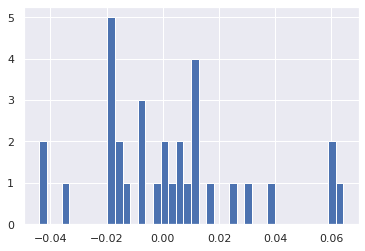

In [25]:
plt.hist(df_train_meta['change_rate_30d'], bins=40)

In [26]:
df_train_meta['label'] = df_train_meta['change_rate_30d'].map(lambda x: 1 if x >= 0 else 0)
df_test_meta['label'] = df_test_meta['change_rate_30d'].map(lambda x: 1 if x >= 0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import models, transforms

In [28]:
class CandleDataset(data.Dataset):

    def __init__(self, files, labels, transform):
        self._files = files
        self._labels = labels
        self._transform = transform

    def __len__(self):
        return len(self._files)

    def __getitem__(self, index):

        img = Image.open(self._files[index]).convert("RGB")

        img_transformed = self._transform(img)

        return img_transformed, self._labels[index]

In [29]:
train_transform = test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [30]:
train_candle_dataset = CandleDataset(
    list(df_train_meta['local_filepath']),
    list(df_train_meta['label']),
    train_transform
)
test_candle_dataset = CandleDataset(
    list(df_test_meta['local_filepath']),
    list(df_test_meta['label']),
    train_transform
)

In [31]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_candle_dataset,
    batch_size,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_candle_dataset,
    batch_size,
    shuffle=False
)

In [ ]:
batch = next(iter(train_dataloader))

In [32]:
plt.rcParams["axes.grid"] = False

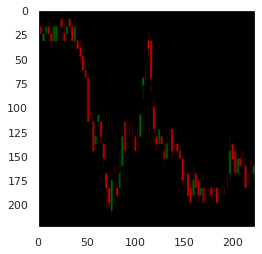

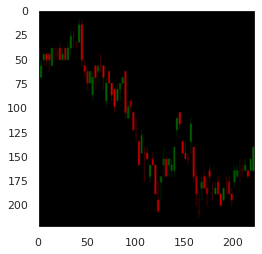

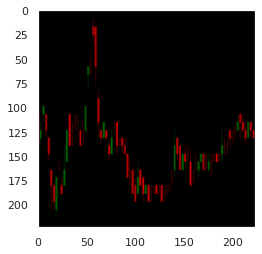

In [ ]:
for i in range(3):
    plt.imshow(batch[0][i].permute(1, 2, 0))
    plt.show()

In [33]:
model = EfficientNet.from_pretrained('efficientnet-b7')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, 2)

Loaded pretrained weights for efficientnet-b7


In [34]:
for name, param in model.named_parameters():
    if '_fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [35]:
for name, param in model.named_parameters():
    print(f'{name} : {param.requires_grad}')

_conv_stem.weight : False
_bn0.weight : False
_bn0.bias : False
_blocks.0._depthwise_conv.weight : False
_blocks.0._bn1.weight : False
_blocks.0._bn1.bias : False
_blocks.0._se_reduce.weight : False
_blocks.0._se_reduce.bias : False
_blocks.0._se_expand.weight : False
_blocks.0._se_expand.bias : False
_blocks.0._project_conv.weight : False
_blocks.0._bn2.weight : False
_blocks.0._bn2.bias : False
_blocks.1._depthwise_conv.weight : False
_blocks.1._bn1.weight : False
_blocks.1._bn1.bias : False
_blocks.1._se_reduce.weight : False
_blocks.1._se_reduce.bias : False
_blocks.1._se_expand.weight : False
_blocks.1._se_expand.bias : False
_blocks.1._project_conv.weight : False
_blocks.1._bn2.weight : False
_blocks.1._bn2.bias : False
_blocks.2._depthwise_conv.weight : False
_blocks.2._bn1.weight : False
_blocks.2._bn1.bias : False
_blocks.2._se_reduce.weight : False
_blocks.2._se_reduce.bias : False
_blocks.2._se_expand.weight : False
_blocks.2._se_expand.bias : False
_blocks.2._project_conv.w

In [36]:
n_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    [param for name, param in model.named_parameters() if param.requires_grad],
    lr=0.01
)

In [37]:
device = 'cpu'

In [ ]:
model.to(device)
model.train()

loss_history = []
acc_history = []

for n in pb(range(n_epochs)):
    epoch_loss = 0.0
    correct_n = 0

    for images, labels in pb(train_dataloader):

        optimizer.zero_grad()

        pred_scores = model(images.to(device))
        loss = criterion(pred_scores, labels.to(device))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        correct_n += torch.sum(torch.argmax(pred_scores, axis=1) == labels.data.to(device))

    epoch_loss /= len(train_dataloader.dataset)
    acc = correct_n.double() / len(train_dataloader.dataset)

    loss_history.append(epoch_loss)
    acc_history.append(acc)

    print(f'epoch : {n}, loss : {epoch_loss}, acc : {acc}')

epoch : 0, loss : 0.853549063205719, acc : 0.4375


epoch : 1, loss : 0.6079665943980217, acc : 0.65625


epoch : 2, loss : 0.7637942582368851, acc : 0.5


epoch : 3, loss : 0.5047188103199005, acc : 0.71875


epoch : 4, loss : 0.26736578345298767, acc : 0.90625


epoch : 5, loss : 0.26655752025544643, acc : 0.90625


epoch : 6, loss : 0.13122629653662443, acc : 0.96875


epoch : 7, loss : 0.27141521126031876, acc : 0.875


epoch : 8, loss : 0.19564498774707317, acc : 0.96875


epoch : 9, loss : 0.19409000128507614, acc : 0.9375


epoch : 10, loss : 0.37549559958279133, acc : 0.8125


epoch : 11, loss : 0.28009982220828533, acc : 0.90625


epoch : 12, loss : 0.37108136899769306, acc : 0.90625


epoch : 13, loss : 0.2474177498370409, acc : 0.90625


epoch : 14, loss : 0.44757022708654404, acc : 0.84375


epoch : 15, loss : 0.20718958717770875, acc : 0.875


epoch : 16, loss : 0.4023305978626013, acc : 0.875


epoch : 17, loss : 0.07805747399106622, acc : 1.0


epoch : 18, loss : 0.07776519434992224, acc : 0.96875


KeyboardInterrupt: ignored

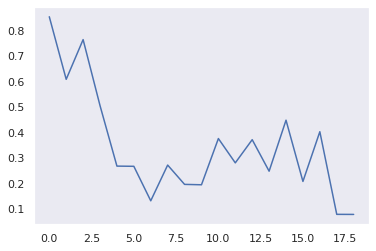

In [ ]:
plt.plot(loss_history)

In [ ]:
plt.plot(acc_history)

In [ ]:
model.to(device)
model.eval()

correct_n = 0

for images, labels in pb(test_dataloader):
    preds = model(images.to(device))
    correct_n += torch.sum(torch.argmax(preds, axis=1) == labels.data.to(device))

acc = correct_n.double() / len(test_dataloader.dataset)

print(f'acc : {acc}')

acc : 0.631578947368421


In [ ]:
correct_n

tensor(12)

In [ ]:
len(df_test_meta)

19

In [38]:
n_data = len(df_test_meta)
N_TRY = 10000

accs = []
for _ in range(N_TRY):
    true_labels = np.random.randint(0, 2, n_data)
    pred_labels = np.random.randint(0, 2, n_data)
    acc = (true_labels==pred_labels).sum() / n_data
    accs.append(acc)

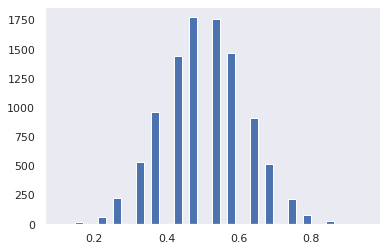

In [43]:
_ = plt.hist(accs, bins=40)

In [46]:
# データ数がlen(df_test_meta)=19であるとき、ランダムに二値分類した場合に、Accuracyが偶然63%以上になる確率
(np.array(accs) > 0.63).sum() / N_TRY

0.1751